##Import Libraries

Gpu

In [ ]:
!nvidia-smi

Sat Mar 18 12:05:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, MaxPooling2D, Dropout, Activation, Convolution2D, BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
#Rotate IMG
import cv2
def rotateImg(img, angle):
    # Load the image
    #img = cv2.imread('image.jpg')

    # Get the image center
    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # Define the rotation angle
    #angle = 45

    # Calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation to the image
    rotated = cv2.warpAffine(img, M, (w, h))

    # Display the original and rotated images
    #cv2.imshow('Original Image', img)
    #cv2.imshow('Rotated Image', rotated)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    return (rotated)

##Load Kaggle dataset

In [ ]:
#Load data frpm kaggle
from google.colab import files
files.upload()

%pip install -q kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
!kaggle datasets download paultimothymooney/breast-histopathology-images --unzip

Saving kaggle.json to kaggle.json
 99% 3.08G/3.10G [00:15<00:00, 281MB/s]
100% 3.10G/3.10G [00:15<00:00, 208MB/s]


In [ ]:
%ls


10253/  10305/  12881/  13018/  14153/  16085/  8980/  9255/
10254/  10306/  12882/  13019/  14154/  16165/  8984/  9256/
10255/  10307/  12883/  13020/  14155/  16166/  9022/  9257/
10256/  10308/  12884/  13021/  14156/  16167/  9023/  9258/
10257/  12241/  12886/  13022/  14157/  16531/  9029/  9259/
10258/  12242/  12890/  13023/  14188/  16532/  9035/  9260/
10259/  12626/  12891/  13024/  14189/  16533/  9036/  9261/
10260/  12748/  12892/  13025/  14190/  16534/  9037/  9262/
10261/  12749/  12893/  13106/  14191/  16550/  9041/  9265/
10262/  12750/  12894/  13400/  14192/  16551/  9043/  9266/
10264/  12751/  12895/  13401/  14209/  16552/  9044/  9267/
10268/  12752/  12896/  13402/  14210/  16553/  9073/  9290/
10269/  12810/  12897/  13403/  14211/  16554/  9075/  9291/
10272/  12811/  12898/  13404/  14212/  16555/  9076/  9319/
10273/  12817/  12900/  13458/  14213/  16568/  9077/  9320/
10274/  12818/  12901/  13459/  14304/  16569/  9078/  9321/
10275/  12819/  12905/  

##Read Images into two classes

In [ ]:
import glob
dir = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)
N_IDC = []
P_IDC = []

for img in dir:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)


##Plot Sample Images

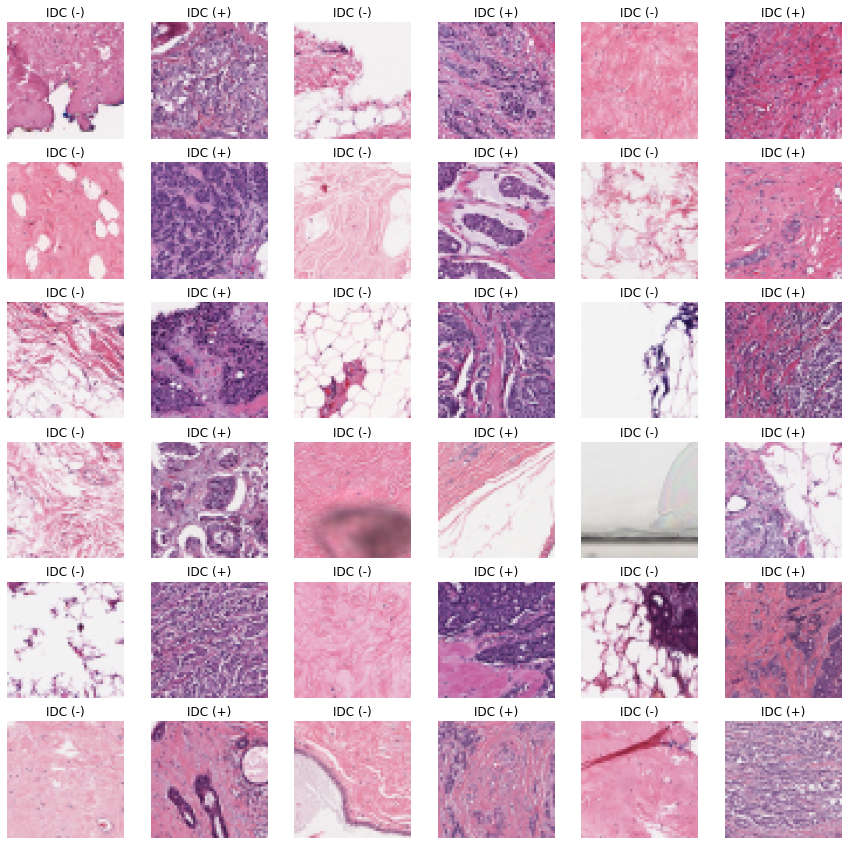

In [ ]:
from keras.preprocessing import image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:

        img = tf.keras.utils.load_img((N_IDC[num]), target_size=(100, 100))
        img = tf.keras.utils.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1

for num in some_can:

        img = tf.keras.utils.load_img((P_IDC[num]), target_size=(100, 100))
        img = tf.keras.utils.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

##Images Handling

In [ ]:
import cv2
import random

print('Total number of images before Augmentation:')
print('Number of IDC(-) Images: ', len (N_IDC))
print('Number of IDC(+) Images: ', len (P_IDC))


non_img_arr = []
can_img_arr = []

for img in N_IDC:

    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (32, 32), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (32, 32), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

    #flip images
    flippedImage = cv2.flip(c_img_size, 0)
    can_img_arr.append([flippedImage, 1])

    #rotate images
    rotateImage=rotateImg(c_img_size,45)
    can_img_arr.append([rotateImage, 1])

print('Total number of images after Augmentation: ')
print('Number of IDC(-) Images: ', len (non_img_arr))
print('Number of IDC(+) Images: ', len (can_img_arr))
print('Image Shape: ', flippedImage.shape)
#print('Image Shape: ', rotateImage.shape)

X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

Total number of images before Augmentation:
Number of IDC(-) Images:  198738
Number of IDC(+) Images:  78786
Total number of images after Augmentation: 
Number of IDC(-) Images:  198738
Number of IDC(+) Images:  236358
Image Shape:  (32, 32, 3)


#plot sample after aug

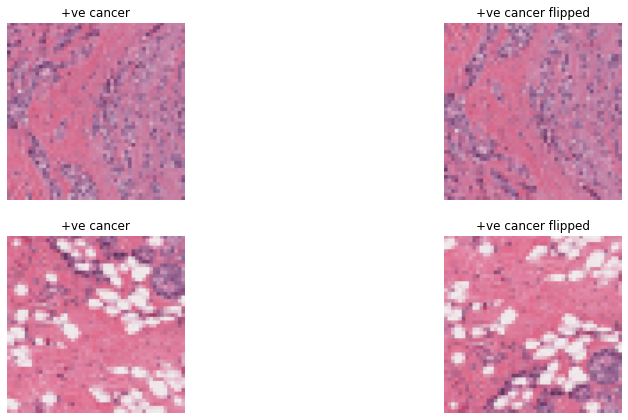

In [ ]:
from keras.preprocessing import image

import cv2

plt.figure(figsize = (15, 15))

s = 0
for i in range (1,3):

        img = tf.keras.utils.load_img((P_IDC[i]), target_size=(100, 100))
        img = tf.keras.utils.img_to_array(img)

        plt.subplot(4, 4, 2*s+1)
        plt.axis('off')
        plt.title('+ve cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

        flippedImg = cv2.flip(img, 0)      #flip
        #rotateImg = rotateImg(img,45)      #Rotate

        plt.subplot(4, 4, 2*s+1)
        plt.axis('off')
        plt.title('+ve cancer flipped')
        plt.imshow(flippedImg.astype('uint8'))
        #plt.imshow(rotateImg.astype('uint8'))

        s += 1

# Plot Image Flip and Rotate

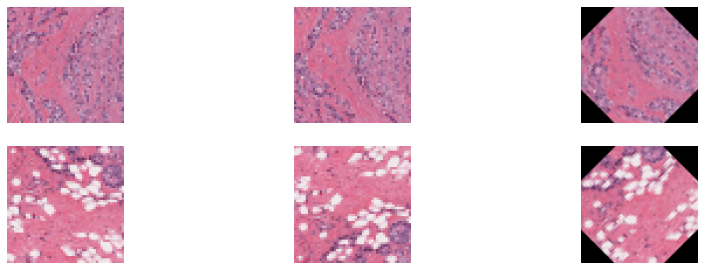

In [ ]:
from keras.preprocessing import image
import cv2

plt.figure(figsize = (15, 15))

s = 0
for i in range (1,3):

        img = tf.keras.utils.load_img((P_IDC[i]), target_size=(100, 100))
        img = tf.keras.utils.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('+ve cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

        flippedImg = cv2.flip(img, 0)


        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('+ve cancer flipped')
        plt.imshow(flippedImg.astype('uint8'))

        s += 1

        rotatedImg= rotateImg(img, 45)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('+ve cancer 45 rotated')
        plt.imshow(rotatedImg.astype('uint8'))

        s += 1

##Split data into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (304567, 32, 32, 3)
Testing Data Shape: (130529, 32, 32, 3)


##Model Configuration

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, MaxPooling2D, Dropout, Activation, Convolution2D, BatchNormalization

_, rows, cols, channels = X_train.shape
input_img = tf.keras.Input(shape=(32, 32,3))

#model=Sequential()

model_1 = Convolution2D(32, (3,3),padding='same')(input_img)
model_1 = Activation('relu')(model_1)
model_1 = BatchNormalization()(model_1)
model_1 = Convolution2D(32, (3, 3),padding='same')(model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu')(model_1)
model_1 = MaxPooling2D(pool_size=(2, 2),padding='same')(model_1)
model_1 = (Dropout(0.2))(model_1)

model_1 = Convolution2D(64, (3, 3),padding='same') (model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu') (model_1)
model_1 = Convolution2D(64, (3, 3),padding='same') (model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu') (model_1)
model_1 = MaxPooling2D(pool_size=(2, 2)) (model_1)
model_1 = Dropout(0.2) (model_1)


model_1 = Convolution2D(128,(3, 3),padding='same') (model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu') (model_1)
model_1 = Dropout(0.2) (model_1)
model_1 = Convolution2D(128,(3, 3),padding='same') (model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu') (model_1)
model_1 = MaxPooling2D(pool_size=(2, 2)) (model_1)
model_1 = Dropout(0.2) (model_1)

model_1 = Convolution2D(256,(3, 3),padding='same') (model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu') (model_1)
model_1 = Dropout(0.2) (model_1)
model_1 = Convolution2D(256, (3, 3),padding='same') (model_1)
model_1 = BatchNormalization() (model_1)
model_1 = Activation('relu') (model_1)
model_1 = MaxPooling2D(pool_size=(2, 2)) (model_1)
model_1 = Dropout(0.2) (model_1)

model_1 = Flatten()(model_1)
#model_1 = tf.keras.Model(input_img, model_1)
#model_1.build(input_img)


In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2B3

# load model
modelEfficientNetV2B3 = EfficientNetV2B3(include_top = False, input_shape = (32, 32,3))(input_img)

modelEfficientNetV2B3 = Flatten()(modelEfficientNetV2B3)

52606240/52606240 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import concatenate
concatenated = concatenate([modelEfficientNetV2B3, model_1])

dense_layer_1 = Dense(64, activation = "sigmoid", name = "dense_layer_1")(concatenated)
dense_layer_2 = Dense(16, activation = "sigmoid", name = "dense_layer_2")(dense_layer_1)
output_layer = Dense(2, activation = "softmax", name = "output_layer")(dense_layer_2)
hybridModel = tf.keras.Model(input_img, output_layer)
hybridModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss = 'binary_crossentropy',
              metrics = [
                        #tf.keras.metrics.TruePositives(name='tp'),
                        #tf.keras.metrics.FalsePositives(name='fp'),
                        #tf.keras.metrics.TrueNegatives(name='tn'),
                        #tf.keras.metrics.FalseNegatives(name='fn'),
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        #tf.keras.metrics.Precision(name='precision'),
                        #tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')])
hybridModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['activation[0][0]']             
 alization)                                                                                   

##Plot the model

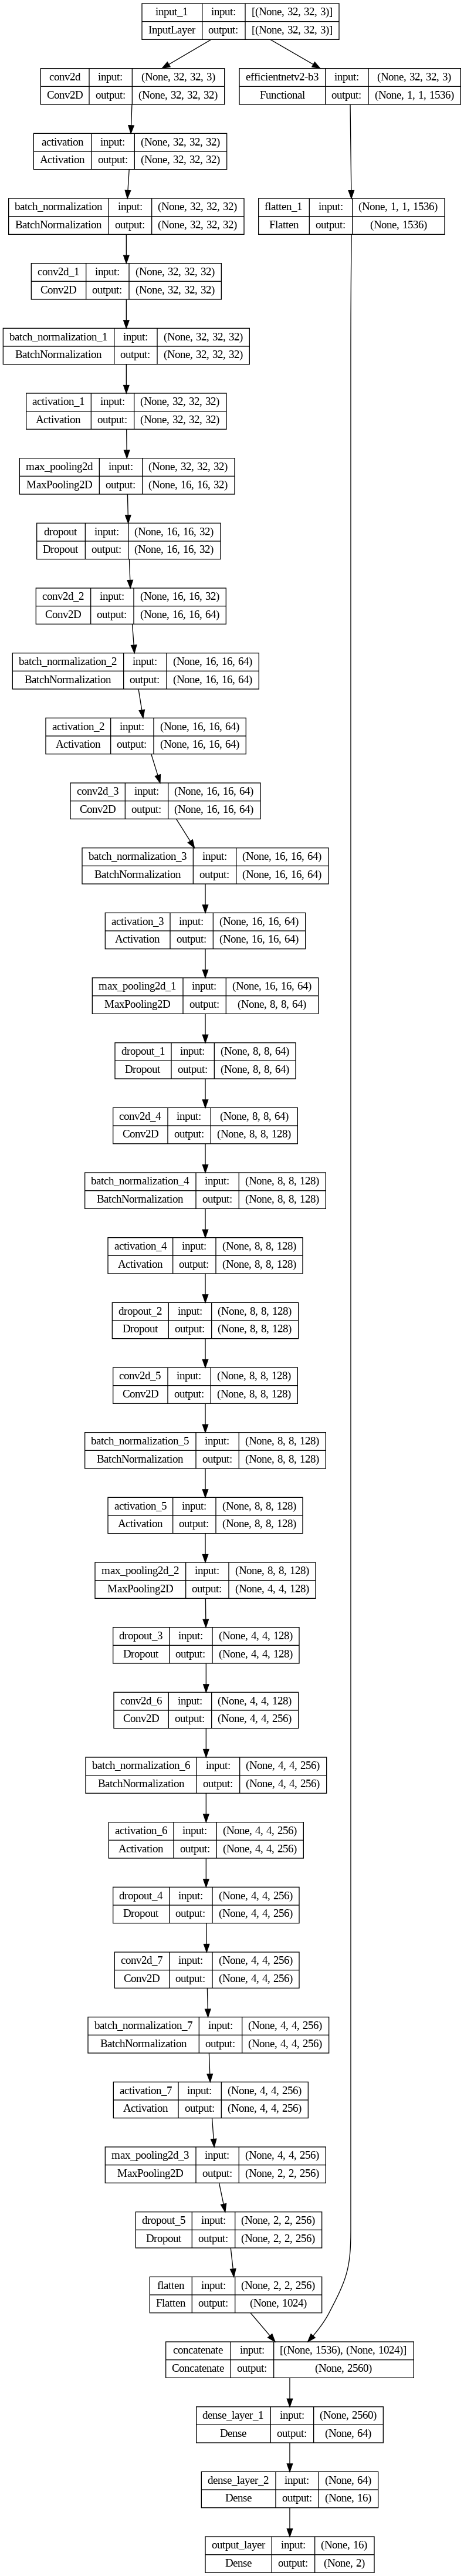

In [ ]:
tf.keras.utils.plot_model(hybridModel, show_shapes=True)

##Model Training

In [ ]:
history = hybridModel.fit(X_train, Y_train,  batch_size=128, #steps_per_epoch = 100,
                    epochs=25, validation_data= (X_test, Y_test))#, callbacks=[tensorboard_callback])

Epoch 1/25
2380/2380 [==============================] - 354s 111ms/step - loss: 0.2134 - accuracy: 0.9171 - auc: 0.9689 - prc: 0.9646 - val_loss: 0.1887 - val_accuracy: 0.9277 - val_auc: 0.9750 - val_prc: 0.9714
Epoch 2/25
2380/2380 [==============================] - 244s 103ms/step - loss: 0.1756 - accuracy: 0.9308 - auc: 0.9767 - prc: 0.9731 - val_loss: 0.1884 - val_accuracy: 0.9237 - val_auc: 0.9708 - val_prc: 0.9651
Epoch 3/25
2380/2380 [==============================] - 257s 108ms/step - loss: 0.1529 - accuracy: 0.9417 - auc: 0.9810 - prc: 0.9776 - val_loss: 0.1501 - val_accuracy: 0.9443 - val_auc: 0.9796 - val_prc: 0.9752
Epoch 4/25
2380/2380 [==============================] - 254s 107ms/step - loss: 0.1342 - accuracy: 0.9499 - auc: 0.9841 - prc: 0.9809 - val_loss: 0.1513 - val_accuracy: 0.9419 - val_auc: 0.9800 - val_prc: 0.9759
Epoch 5/25
2380/2380 [==============================] - 243s 102ms/step - loss: 0.1148 - accuracy: 0.9583 - auc: 0.9869 - prc: 0.9841 - val_loss: 0.1393

# Classification Report


In [ ]:
# Test Predictions
preds = hybridModel.predict(X_test, verbose=1)

# Take the highest probability scores to get index of predictions for test images
y_pred = np.argmax(preds, axis=1)

# Get labels of test images
y_true = y_test

# Classification Report

from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score,classification_report, roc_auc_score, roc_curve, confusion_matrix, auc ,matthews_corrcoef
print("Report of the result of Dynamic model : \n Confusion matrix : \n {} \n\nAccuracy Score:{}% \n\nPrecision Score:{}% \n\nRecall Score: {}% \n\nf1 score Score: {}%  \n\nmcc: {}%\n\nClassification Report : \n  {}".format(
      confusion_matrix(y_test, y_pred),
      round(accuracy_score(y_test, y_pred),3)*100 ,
      round(precision_score(y_test, y_pred),3)*100,
      round(recall_score(y_test, y_pred),3)*100,
      round(f1_score(y_test, y_pred),3)*100,
      round(matthews_corrcoef(y_test, y_pred),3)*100,
      classification_report(y_test, y_pred)))

4080/4080 [==============================] - 90s 21ms/step
Report of the result of Dynamic model : 
 Confusion matrix : 
 [[104701   1487]
 [  3318  21023]] 

Accuracy Score:96.3% 

Precision Score:93.4% 

Recall Score: 86.4% 

f1 score Score: 89.7%  

mcc: 87.6%

Classification Report : 
                precision    recall  f1-score   support

           0       0.97      0.99      0.98    106188
           1       0.93      0.86      0.90     24341

    accuracy                           0.96    130529
   macro avg       0.95      0.92      0.94    130529
weighted avg       0.96      0.96      0.96    130529



Save Model

In [ ]:
hybridModel.save("hybridModel_1")

#PLot model loss and accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

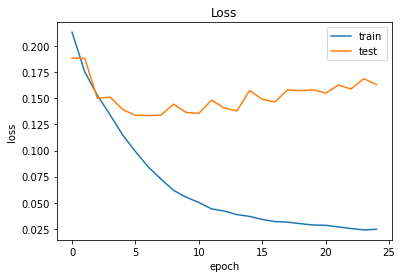

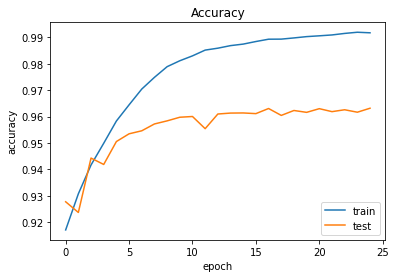

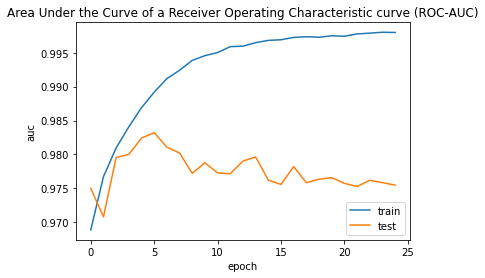

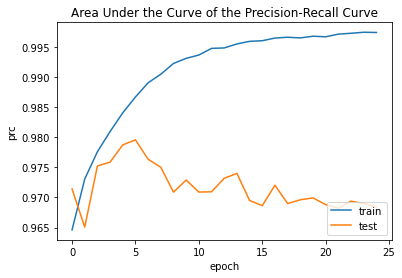

In [ ]:
#plot loss and accuracy
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'upper right')
plt.show

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

'''
plt.figure(3)
plt.plot(history.history['tp'])
plt.plot(history.history['val_tp'])
plt.title("TruePositives")
plt.ylabel("TruePositives")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

plt.figure(4)
plt.plot(history.history['fp'])
plt.plot(history.history['val_fp'])
plt.title("FalsePositives")
plt.ylabel("FalsePositives")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

plt.figure(5)
plt.plot(history.history['tn'])
plt.plot(history.history['val_tn'])
plt.title("TrueNegatives")
plt.ylabel("TrueNegatives")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

plt.figure(6)
plt.plot(history.history['fn'])
plt.plot(history.history['val_fn'])
plt.title("FalseNegatives")
plt.ylabel("FalseNegatives")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

plt.figure(7)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title("recall")
plt.ylabel("recall")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

plt.figure(8)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title("precision")
plt.ylabel("precision")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

'''

plt.figure(9)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title("Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC)")
plt.ylabel("auc")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

plt.figure(10)
plt.plot(history.history['prc'])
plt.plot(history.history['val_prc'])
plt.title("Area Under the Curve of the Precision-Recall Curve")
plt.ylabel("prc")
plt.xlabel("epoch")
plt.legend(['train','test'], loc = 'lower right')
plt.show

##Plot Sample Prediction

In [ ]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 90
img_plot(X_test, index)

input = X_test[index:index+1]
pred = hybridModel.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

Load Model and Predict Classes

In [ ]:
hybridModel = tf.keras.models.load_model('hybridModel_1')

test_predictions_baseline = hybridModel.predict(X_test, batch_size=32)
test_predictions_baseline = np.argmax(test_predictions_baseline, axis=1)

4080/4080 [==============================] - 104s 25ms/step


#Confusion Matrix

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(y_test, test_predictions_baseline)

Model Evaluation

In [ ]:
baseline_results = hybridModel.evaluate(X_test, Y_test,
                                  batch_size=128, verbose=0)
for name, value in zip(hybridModel.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.16330377757549286
accuracy :  0.9631882309913635
auc :  0.9754758477210999
prc :  0.9684486389160156

